In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pd_reader
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds
import datetime
import math

%matplotlib inline

In [3]:
## Feed Data into backtrader

aapl = pd.read_csv(".\stock_data\AAPL.csv", index_col=0, parse_dates=True)

aapl_feed = bt.feeds.PandasData(dataname=aapl, openinterest=-1)

In [6]:
## Startegy
class BuyAndHoldStrategy(bt.Strategy):
    
    def __init__(self):
        self.pending_orders = dict()
        
    def notify_order(self, order):
        if not order is None:
            if order.status == order.Completed:
                symbol = self.pending_orders[order.ref]
                print('%s: %s order filled' % (self.datetime.date(), symbol))
            
    #! this line of code is part of solution described above
    def prenext(self):
        self.next()
    
    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        
        for i, d in enumerate(self.datas):
            
            #! this line of code is part of solution described above
            #! check if instrument is available for trading
            can_trade = self.datetime.date() in self.datas[i]._dataname.index
            no_position = not self.getposition(self.datas[i])

            if can_trade:
                
                # we want to allocate $20000 in each instrument, but as order will
                # be executed only at the next days's open price, we leave a margin of $1000
                # to make sure that order will not be cancelled due to lack of cash
                order = self.order_target_value(data=self.datas[i], target=1000*np.sign(self.datas[i]._dataname['volume'].loc[self.datetime.date()]))
                if not order is None:
                    self.pending_orders[order.ref] = d._name

                print('%s: %s order submitted' % (self.datetime.date(), d._name))       

In [7]:
## Initialize backtesting   
cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.setcash(100000.0)
cerebro.adddata(aapl_feed, name="AAPL")
cerebro.addstrategy(BuyAndHoldStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

strats = cerebro.run()
cplots = cerebro.plot()

2018-01-02: AAPL order submitted
2018-01-03: AAPL order filled
2018-01-03: AAPL order submitted
2018-01-04: AAPL order submitted
2018-01-05: AAPL order submitted
2018-01-08: AAPL order submitted
2018-01-09: AAPL order submitted
2018-01-10: AAPL order submitted
2018-01-11: AAPL order submitted
2018-01-12: AAPL order submitted
2018-01-16: AAPL order submitted
2018-01-17: AAPL order submitted
2018-01-18: AAPL order submitted
2018-01-19: AAPL order submitted
2018-01-22: AAPL order submitted
2018-01-23: AAPL order submitted
2018-01-24: AAPL order submitted
2018-01-25: AAPL order submitted
2018-01-26: AAPL order submitted
2018-01-29: AAPL order submitted
2018-01-30: AAPL order submitted
2018-01-31: AAPL order submitted
2018-02-01: AAPL order submitted
2018-02-02: AAPL order submitted
2018-02-05: AAPL order filled
2018-02-05: AAPL order submitted
2018-02-06: AAPL order filled
2018-02-06: AAPL order submitted
2018-02-07: AAPL order submitted
2018-02-08: AAPL order submitted
2018-02-09: AAPL or

<IPython.core.display.Javascript object>

Start date,2018-01-02
End date,2021-12-31
Total months,48
,Backtest
Annual return,0.4%
Cumulative returns,1.6%
Annual volatility,0.3%
Sharpe ratio,1.22
Calmar ratio,0.87
Stability,0.92
Max drawdown,-0.5%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.46,2018-10-03,2019-01-03,2019-09-11,246
1,0.37,2020-02-12,2020-03-23,2020-06-01,79
2,0.22,2020-09-01,2020-09-18,2020-12-28,85
3,0.19,2021-01-26,2021-03-08,2021-07-06,116
4,0.14,2018-01-18,2018-02-08,2018-02-26,28


Stress Events,mean,min,max
New Normal,0.00%,-0.14%,0.11%


Top 10 long positions of all time,max
AAPL,1.18%


Top 10 short positions of all time,max


Top 10 positions of all time,max
AAPL,1.18%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:86: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict

Summary stats,All trades,Long trades
Total number of round_trips,46.00,46.00
Percent profitable,0.89,0.89
Winning round_trips,41.00,41.00
Losing round_trips,5.00,5.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$1629.52,$1629.52
Gross profit,$1646.52,$1646.52
Gross loss,$-17.00,$-17.00
Profit factor,$96.84,$96.84
Avg. trade net profit,$35.42,$35.42
Avg. winning trade,$40.16,$40.16
Avg. losing trade,$-3.40,$-3.40
Ratio Avg. Win:Avg. Loss,$11.81,$11.81
Largest winning trade,$578.03,$578.03
Largest losing trade,$-5.96,$-5.96


Duration stats,All trades,Long trades
Avg duration,417 days 20:20:52.195652,417 days 20:20:52.195652
Median duration,456 days 12:00:00,456 days 12:00:00
Longest duration,702 days 00:00:00,702 days 00:00:00
Shortest duration,43 days 00:00:00,43 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,0.03%,0.03%
Avg returns winning,0.04%,0.04%
Avg returns losing,-0.00%,-0.00%
Median returns all round_trips,0.01%,0.01%
Median returns winning,0.01%,0.01%
Median returns losing,-0.00%,-0.00%
Largest winning trade,0.57%,0.57%
Largest losing trade,-0.01%,-0.01%


Symbol stats,AAPL
Avg returns all round_trips,0.03%
Avg returns winning,0.04%
Avg returns losing,-0.00%
Median returns all round_trips,0.01%
Median returns winning,0.01%
Median returns losing,-0.00%
Largest winning trade,0.57%
Largest losing trade,-0.01%


Profitability (PnL / PnL total) per name,
symbol,
AAPL,100.00%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


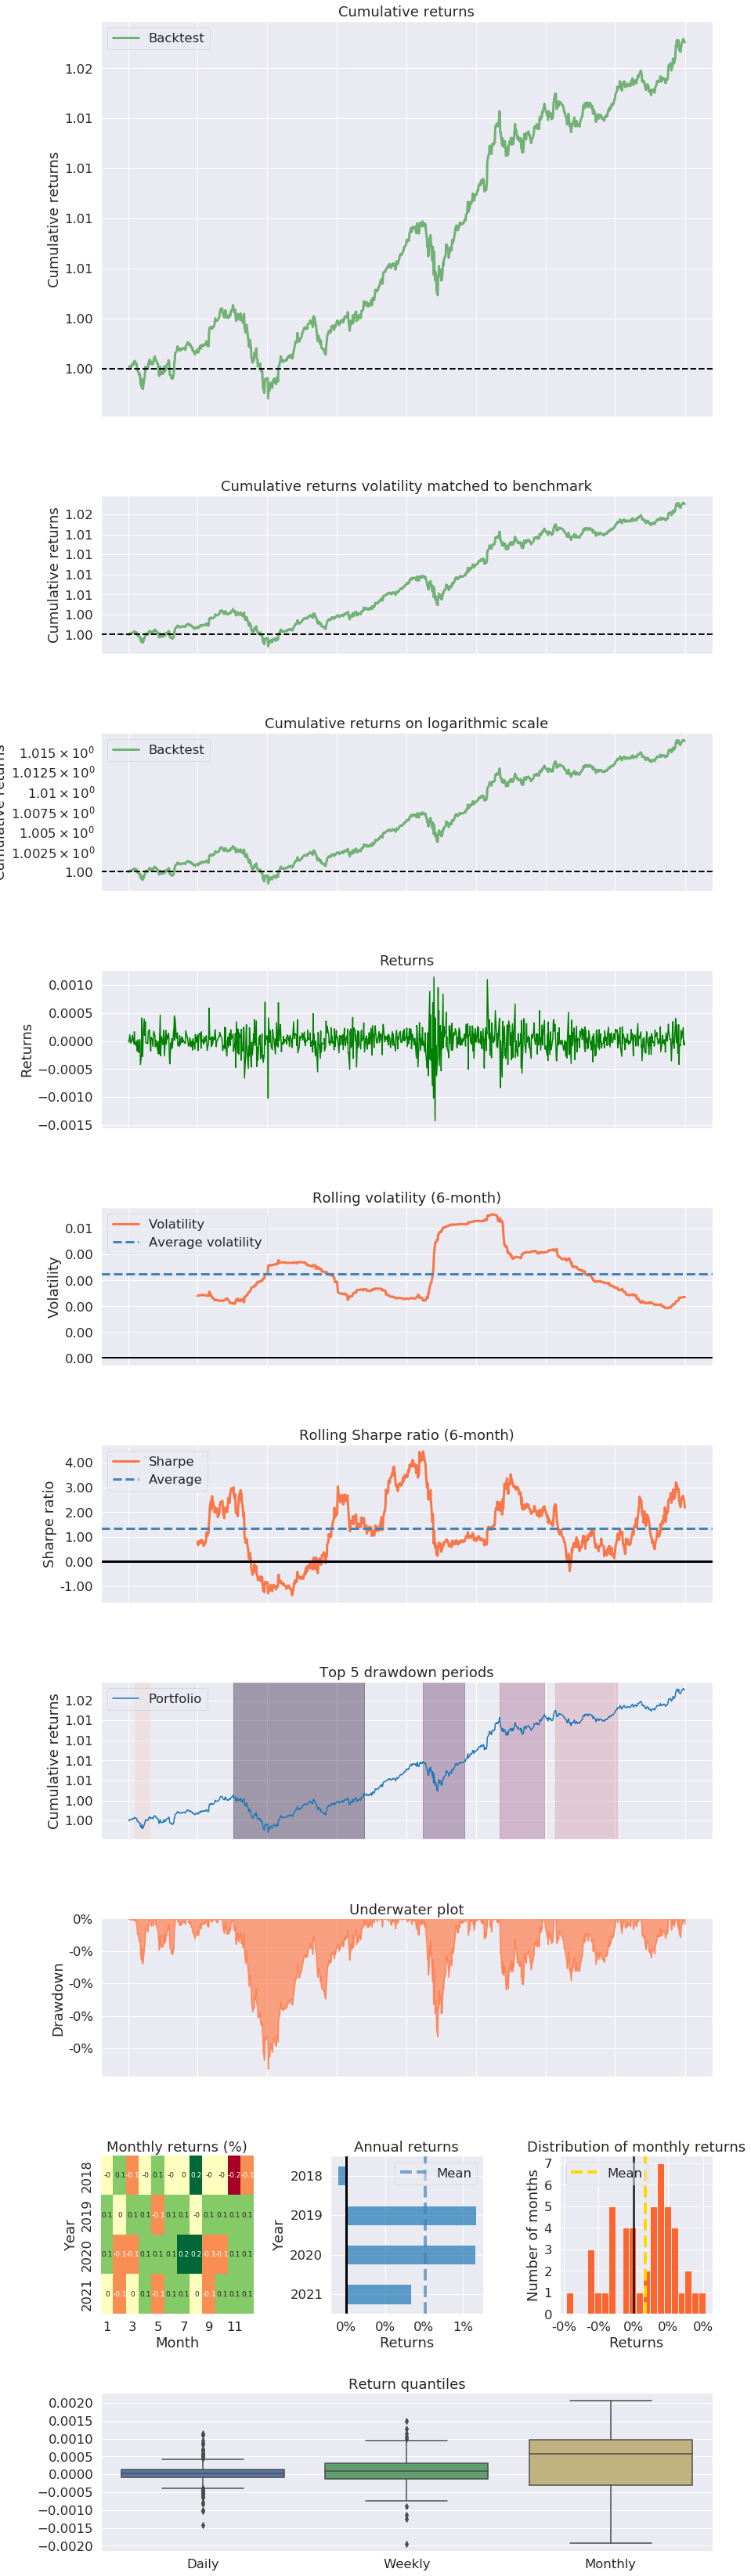

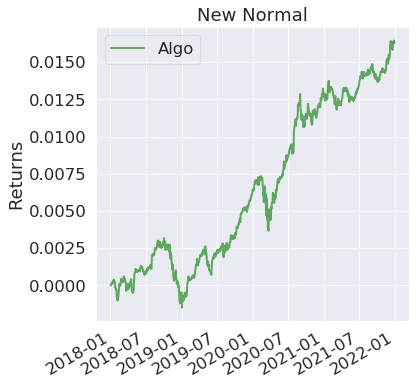

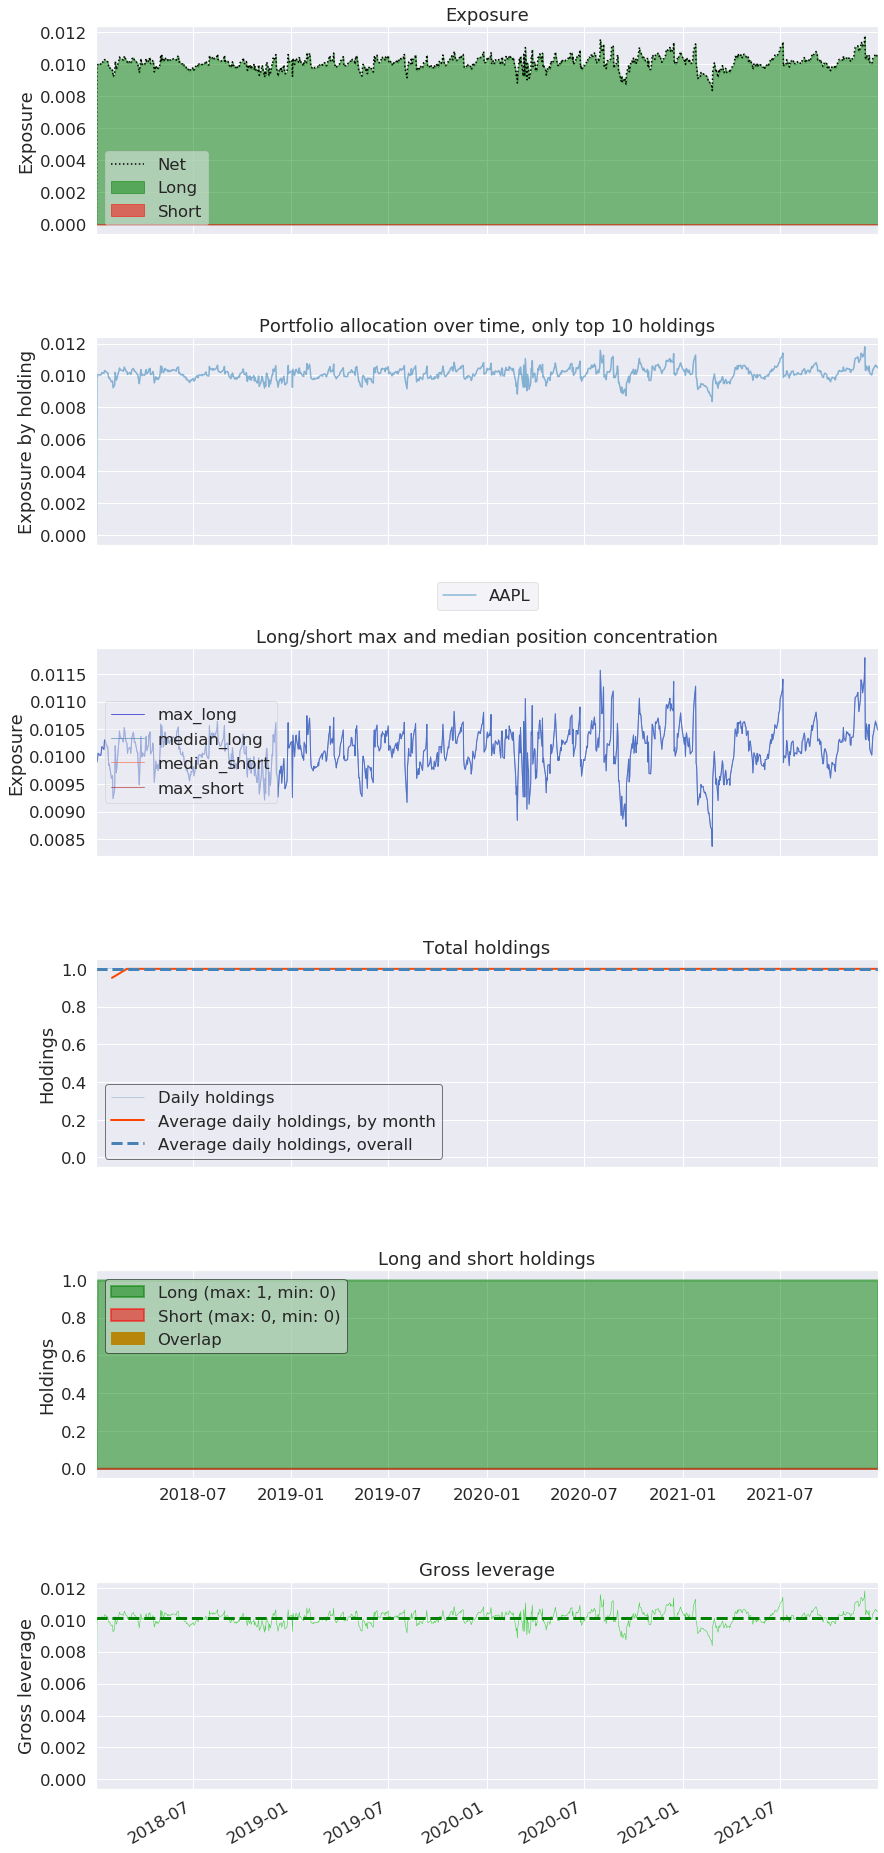

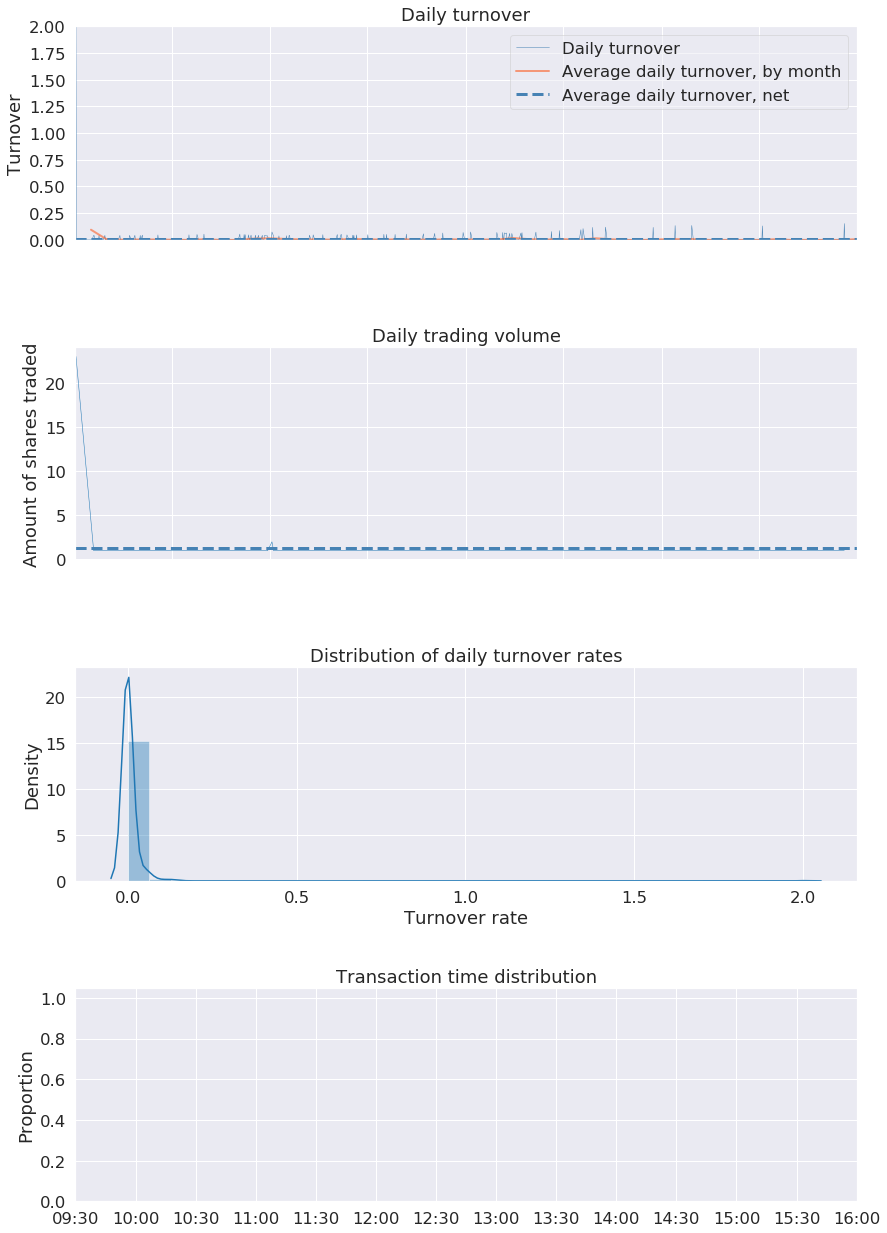

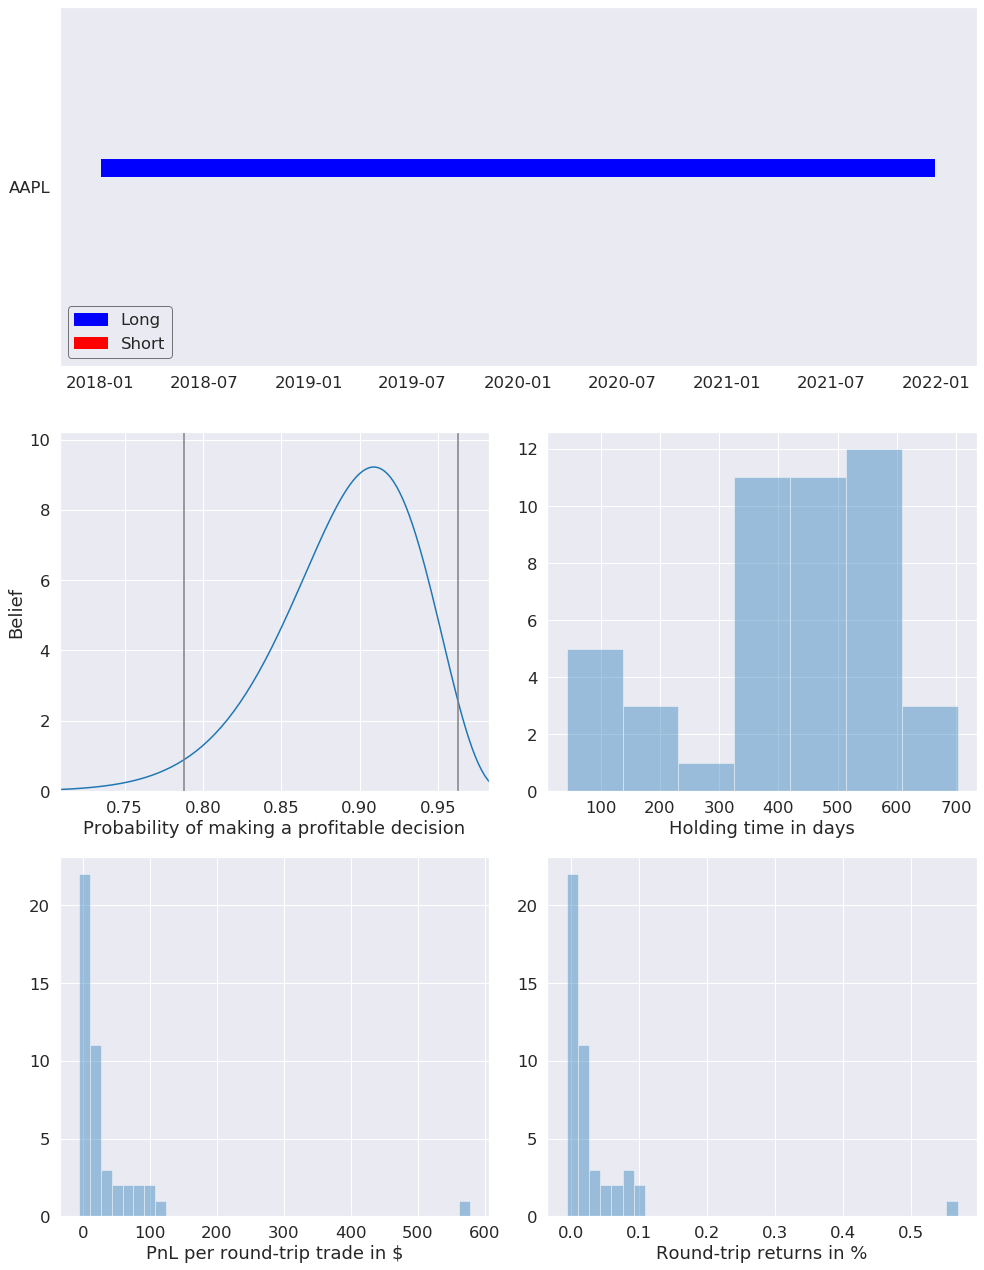

In [9]:
%matplotlib inline
import pyfolio as pf
pyfoliozer = strats[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # live_start_date='2005-05-01',  # This date is sample specific
    round_trips=True)